# Foundations of Data Mining: Assignment 4

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

**Deadline:** Thursday, April 12, 2018

In [4]:
# Please fill in your names here
NAME_STUDENT_1 = "Koen Klaren"
NAME_STUDENT_2 = "Jan Blans"

In [11]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "all"

###### Backpropagation (6 points)

Figure 1 illustrates a simple neural network model.

![Figure 1](images/a4_network.png)

It has single input $x$, and three layers with respectively one, two, and one neurons. The activation function of the neurons is ReLU. 

The parameters $w_1$, $w_2$, $w_3$, $w_4$, and $w_5$ (no biases) are initialized to the following values $w_1 = 2, w_2 = 1$, $w_3 = 2$, $w_4 = 4$, and $w_5 = 1$. Implement a single update step of the gradient descent algorithm by hand. Run the update state for the data point $(x=2, y=3)$:

The goal is to model the relationship between two continuous variables. The learning rate is set to $0.1$

Provide the solution in the following format:

- A choice for a loss function 
- Compute graph for training the neural network
- Partial derivative expression for each of the parameters in the model
- The update expression for each of the parameters for each of the data-points
- The final value of all five parameters after the single step in the gradient descent algorithm

The Python code for simple computational graph nodes, as seen in the tutorial session, is provided in the cell below (run the cell to load the code, and again to run the code). Extend the nodes so they can be used to implement the network described above. Implement the network with the same initial weights and the correct learning rate, and verify your hand-made calculations. Add comments to your code or provide a separate description to explain the changes you have made.

In [33]:
# %load basic_graph.py
'''
Implementations of nodes for a computation graph. Each node
has a forward pass and a backward pass function, allowing
for the evaluation and backpropagation of data.
'''

from abc import ABC, abstractmethod
import math
import time


class Node(object):

    def __init__(self, inputs):
        self.inputs = inputs

    @abstractmethod
    def forward(self):
        ''' Feed-forward the result '''
        raise NotImplementedError("Missing forward-propagation method.")

    @abstractmethod
    def backward(self, d):
        ''' Back-propagate the error
            d is the delta of the subsequent node in the network '''
        raise NotImplementedError("Missing back-propagation method.")


class ConstantNode(Node):

    def __init__(self, value):
        self.output = value

    def forward(self):
        return self.output

    def backward(self, d):
        pass


class VariableNode(Node):

    def __init__(self, value):
        self.output = value

    def forward(self):
        return self.output

    def backward(self, d):
        self.output -= 0.1 * d # Gradient Descent


class AdditionNode(Node):

    def forward(self):
        self.output = sum([i.forward() for i in self.inputs])
        return self.output

    def backward(self, d):
        for i in self.inputs:
            i.backward(d)


class MultiplicationNode(Node):

    def forward(self):
        self.output = self.inputs[0].forward() * self.inputs[1].forward()
        return self.output

    def backward(self, d):
        self.inputs[0].backward(d * self.inputs[1].output)
        self.inputs[1].backward(d * self.inputs[0].output)


class MSENode(Node):

    def forward(self):
        self.output = 0.5 * (
            self.inputs[0].forward() - self.inputs[1].forward())**2
        return self.output

    def backward(self, d):
        self.inputs[0].backward(d * (self.inputs[0].output - self.inputs[1].output))
        self.inputs[1].backward(d * (self.inputs[1].output - self.inputs[0].output))


class SigmoidNode(Node):

    def forward(self):
        self.output = 1.0 / (1.0 + math.exp(-self.inputs[0].forward()))
        return self.output

    def backward(self, d):
        self.inputs[0].backward(d * self.output * (1.0 - self.output))

        
# Implement the ReLU activation function
class ReLUNode(Node):

    def forward(self):
        self.output = max(self.inputs[0].forward(), 0)
        return self.output

    def backward(self, d):
        if (self.output >= 0):
            self.inputs[0].backward(d)
        else:
             # Because derivative is not defined, 0 is passed
            self.inputs[0].backward(0)

class TanhNode(object):

    def forward(self):
        raise NotImplementedError("Forward pass for tanh activation node has not been implemented yet.")

    def backward(self, d):
        raise NotImplementedError("Backward pass for tanh activation node has not been implemented yet.")

# Example graph as shown in MLP lecture slides
# class SampleGraph(object):

#     def __init__(self, x, y, w, b):
#         ''' x: input
#             y: expected output
#             w: initial weight
#             b: initial bias '''
#         self.w = VariableNode(w)
#         self.b = VariableNode(b)
#         self.graph = MSENode([
#             AdditionNode([
#                 MultiplicationNode([
#                     ConstantNode(x),
#                     self.w
#                 ]),
#                 MultiplicationNode([
#                     self.b,
#                     ConstantNode(1)
#                 ])
#             ]),
#             ConstantNode(y)
#         ])

#     def forward(self):
#         return self.graph.forward()

#     def backward(self, d):
#         self.graph.backward(d)

class AssignmentGraph(object):

    def __init__(self, x, y, w1, w2, w3, w4, w5):
        self.n1 = Neuron([ConstantNode(x)], [w1], 'relu')
        self.n2 = Neuron([self.n1], [w2], 'relu')
        self.n3 = Neuron([self.n1], [w3], 'relu')
        self.n4 = Neuron([self.n2, self.n3], [w4, w5], 'relu')
        
        self.out = self.n4
        self.graph = MSENode([
            self.out,
            ConstantNode(y)
        ])

    def forward(self):
        return self.graph.forward()

    def backward(self, d):
        self.graph.backward(d)


class Neuron(Node):

    def __init__(self, inputs, weights, activation):
        ''' weights: list of initial weights, same length as inputs '''
        self.inputs = inputs
        # Initialize a weight for each input
        self.weights = [VariableNode(weight) for weight in weights]
        # Neurons normally have a bias, ignore for this assignment
        #self.bias = VariableNode(bias, "b")

        # Multiplication node for each pair of inputs and weights
        mults = [MultiplicationNode([i, w]) for i, w, in zip(self.inputs, self.weights)]
        # Neurons normally have a bias, ignore for this assignment
        #mults.append(MultiplicationNode([self.bias, ConstantNode(1)]))

        # Sum all multiplication results
        added = AdditionNode(mults)

        # Apply activation function
        if activation == 'sigmoid':
            self.graph = SigmoidNode([added])
        elif activation == 'relu':
            self.graph = ReLUNode([added])
        elif activation == 'tanh':
            self.graph = TanhNode([added])
        else:
            raise ValueError("Unknown activation function.")

    def forward(self):
        self.output = self.graph.forward()
        return self.output

    def backward(self, d):
        self.graph.backward(d)

    def set_weights(self, new_weights):
        for i in len(new_weights):
            self.weights[i].output = new_weights[i]

    def get_weights(self):
        return [weight.output for weight in self.weights]

if __name__ == '__main__':
    print("Loaded simple graph nodes")
    
    ag = AssignmentGraph(x=2, y=3, w1=2, w2=1, w3=2, w4=4, w5=1)
    ag.forward()
    prediction = ag.out.output
    print("Initial prediction is", prediction)
    
    ag.backward(1)
    print('w1:', ag.n1.get_weights())
    print('w2:', ag.n2.get_weights())
    print('w3:', ag.n3.get_weights())
    print('w4, w5:', ag.n4.get_weights())
    
    # Example network
    #sg = SampleGraph(2, 2, 2, 1)
    #prediction = sg.forward()
    #print("Initial prediction is", prediction)
    #sg.backward(1)
    #print("w has new value", sg.w.output)
    #print("b has new value", sg.b.output)

    # Run your network here

'\nImplementations of nodes for a computation graph. Each node\nhas a forward pass and a backward pass function, allowing\nfor the evaluation and backpropagation of data.\n'

Loaded simple graph nodes


220.5

Initial prediction is 24
w1: [-23.200000000000003]
w2: [-32.6]
w3: [-6.4]
w4, w5: [-4.4, -15.8]


## Training Deep Models (3 points)

The model in the example code below performs poorly as its depth increases. Train this model on the MNIST digit detection task. 

Examine its training performance by gradually increasing its depth:
- Set the depth to 1 hidden layer
- Set the depth to 2 hidden layers
- Set the depth to 3 hidden layers

Modify the model such that you improve its performance when its depth increases. Train the new model again for the different depths:
- Set the depth to 1 hidden layer
- Set the depth to 2 hidden layers
- Set the depth to 3 hidden layers

Submit an explanation for the limitation of the original model. Explain your modification. 
Submit your code and 6 plots (can be overlaid) for the training performance of both models with different depths. 



In [35]:
# (You don't need to change this part of the code)
from __future__ import print_function
import numpy as np
np.random.seed(1234)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils


import matplotlib.pyplot as plt

batch_size = 128
nb_classes = 10
nb_epoch = 10

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# (You don't need to change this part of the code)
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [ ]:
# Use this parameter to change the depth of the model
number_hidden_layers = 1  # Number of hidden layers

In [ ]:
# Model
model = Sequential()
model.add(Dense(512, input_shape=(784,), activation='sigmoid'))
model.add(Dropout(0.2))

while number_hidden_layers > 1:
    model.add(Dense(512))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.2))
    number_hidden_layers -= 1


model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


In [ ]:
# Training (You don't need to change this part of the code)
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## MNIST Calculator (6 points)

During the lectures you have seen a CNN model that can be successfully trained to classify the MNIST images. You have also seen how a RNN model that can be trained to implement addition of two numbers. You now need to build a model that is a combination of convolutional layers and recurrent cells. 

Using the KERAS library, design and train a model that produces a sum of a sequence of MNIST images. More specifically, the model should input a sequence of 10 images and compute the cumulative sum of the digits represented by the images.

For example:

Input 1: ![294](images/a3ex1.png)

Output 1: 46

Input 2: ![61](images/a3ex2.png)

Output 2: 43

Your solutions should include:
- Python code that formats the MNIST dataset such that it can be used for traning and testing your model
- Implementation in keras of your model (for training and testing)
- Performance on the model on test data
- Justification (in text) of your decisions for the model architecture (type of layers, activation functions, loss function, regularization and training hyperparameters)

Note: Use the 60000/10000 train/test split of the MNIST dataset


In [180]:
def digit_encode(digit):
    return [1 if digit == i else 0 for i in range(10)]

def num_encode(num):
    return [digit_encode(int(digit)) for digit in str(num).zfill(2)]

def digit_decode(enc):
    if isinstance(enc, list) or isinstance(enc, np.ndarray):
        return np.argmax(enc)
    return enc
    
def num_decode(enc):
    return ''.join([str(digit_decode(enc)) for enc in enc])

Shape before:
(60000, 28, 28)
(60000,)

Shape after:
(1000, 10, 28, 28, 1)
(1000, 2, 10)

Example entry:


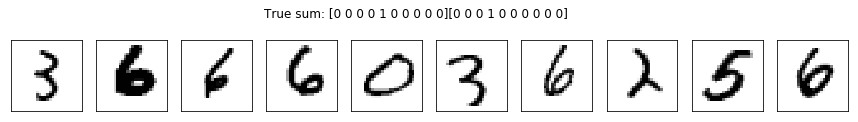

In [175]:
from keras.datasets import mnist

# Create dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('Shape before:')
print(X_train.shape)
print(y_train.shape)

SEQUENCE_LENGTH = 10

def make_dataset(X, y, random_state=None):
    random = np.random.RandomState(random_state)
    
    # "Shuffle" input set
    indices = random.permutation(len(X))
    indices = np.split(indices, len(indices) // SEQUENCE_LENGTH)
    
    X_new = [[X[i] for i in chunk] for chunk in indices]
    y_new = [num_encode(np.sum([y[i] for i in chunk])) for chunk in indices]
    
    return (
        np.array(X_new).reshape(len(X_new), SEQUENCE_LENGTH, 28, 28, 1), 
        np.array(y_new)
    )

def print_entry(sequence, true_val, pred_val=None):
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    fig.suptitle(
        'True sum: {}'.format(num_decode(true_val)) + 
        ('' if pred_val is None else ' - Predicted sum: {}'.format(num_decode(pred_val)))
    )
    
    for i, img in enumerate(sequence):
        plt.sca(axes[i])
        axes[i].xaxis.set_visible(False)
        axes[i].yaxis.set_visible(False)
        plt.imshow(np.squeeze(img), cmap='binary')
    
X_train, y_train = make_dataset(X_train, y_train, 0)
X_test, y_test = make_dataset(X_test, y_test, 0)

X_train = X_train[:1000]
y_train = y_train[:1000]

print()
print('Shape after:')
print(X_train.shape)
print(y_train.shape)

print()
print('Example entry:')
print_entry(X_train[0], y_train[0])

In [186]:
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, LSTM, RepeatVector, Activation, Dense

model = Sequential()

# CNN
model.add(TimeDistributed(
    Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax'),
    ]),
    input_shape=(SEQUENCE_LENGTH, 28, 28, 1)
))

# RNN
RNN = LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

model.add(RNN(HIDDEN_SIZE))
# Max result is 9*10=90, so max length = 2
model.add(RepeatVector(2))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far. 
    # This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(TimeDistributed(Dense(10)))
model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_33 (TimeDis (None, 10, 10)            1199882   
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               71168     
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 2, 128)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 2, 128)            131584    
_________________________________________________________________
time_distributed_34 (TimeDis (None, 2, 10)             1290      
_________________________________________________________________
activation_6 (Activation)    (None, 2, 10)             0         
Total params: 1,403,924
Trainable params: 1,403,924
Non-trainable params: 0
_________________________________________________________________


Iteration 1
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 16s 16ms/step - loss: 2.2871 - acc: 0.2170 - val_loss: 2.2642 - val_acc: 0.2630


[[0.095 0.093 0.098 0.107 0.114 0.106 0.096 0.098 0.098 0.095]
 [0.092 0.089 0.097 0.111 0.123 0.109 0.093 0.097 0.097 0.092]] [4 4]


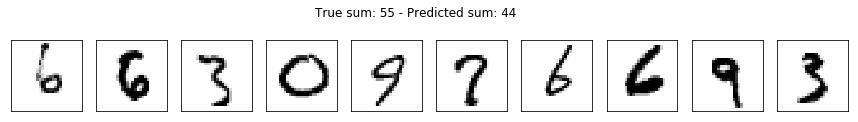

[[0.095 0.093 0.098 0.107 0.114 0.106 0.096 0.098 0.098 0.095]
 [0.092 0.089 0.097 0.111 0.123 0.109 0.093 0.097 0.097 0.092]] [4 4]


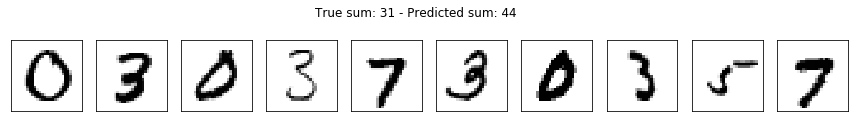

[[0.095 0.093 0.098 0.107 0.114 0.106 0.096 0.098 0.098 0.095]
 [0.092 0.089 0.097 0.111 0.123 0.109 0.093 0.097 0.097 0.092]] [4 4]


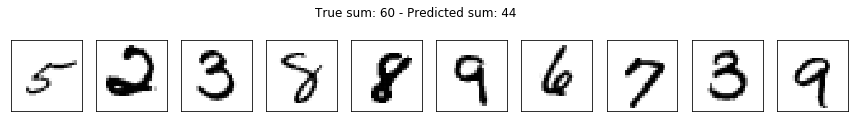

[[0.095 0.093 0.098 0.107 0.114 0.106 0.096 0.098 0.098 0.095]
 [0.092 0.089 0.097 0.111 0.123 0.109 0.093 0.097 0.097 0.092]] [4 4]


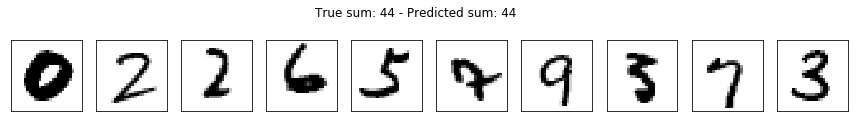

[[0.095 0.093 0.098 0.107 0.114 0.106 0.096 0.098 0.098 0.095]
 [0.092 0.089 0.097 0.111 0.123 0.109 0.093 0.097 0.097 0.092]] [4 4]


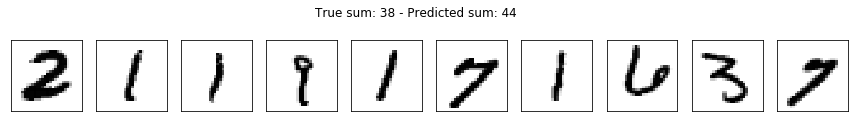

In [187]:
NUM_ITERATIONS = 1
BATCH_SIZE = 128

for iteration in range(1, NUM_ITERATIONS + 1):
    print('Iteration {}'.format(iteration))
    model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=1, validation_data=(X_test, y_test))
    
    # Select samples from the validation set at random so we can visualize errors.
    for i in range(5):
        index = np.random.randint(0, len(X_test))
        rowx, rowy = X_test[np.array([index])], y_test[np.array([index])]
        preds = model.predict_classes(rowx, verbose=0)
        
        print(model.predict(rowx, verbose=0)[0], model.predict_classes(rowx, verbose=0)[0])
        
        
        print_entry(rowx[0], rowy[0], preds[0])
        plt.show()
    


##### Provide your justification here